In [1]:
%matplotlib notebook

In [2]:
from numpy import arange, array, concatenate, newaxis, linspace
import matplotlib.pyplot as plt
from pn_helpers import *

In [3]:
raw_mne = get_raw_mne_data()
raw_mne

<RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>

In [4]:
raw_mne.info

<Info | 8 non-empty values
 bads: []
 ch_names: Fz, FC3, FC1, FCz, FC2, FC4, C5, C3, C1, Cz, C2, C4, C6, CP3, ...
 chs: 22 EEG, 3 EOG, 1 STIM
 custom_ref_applied: False
 dig: 25 items (3 Cardinal, 22 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 26
 projs: []
 sfreq: 250.0 Hz
>

In [5]:
signal = raw_mne.get_data()
signal.shape

(26, 96735)

<IPython.core.display.Javascript object>


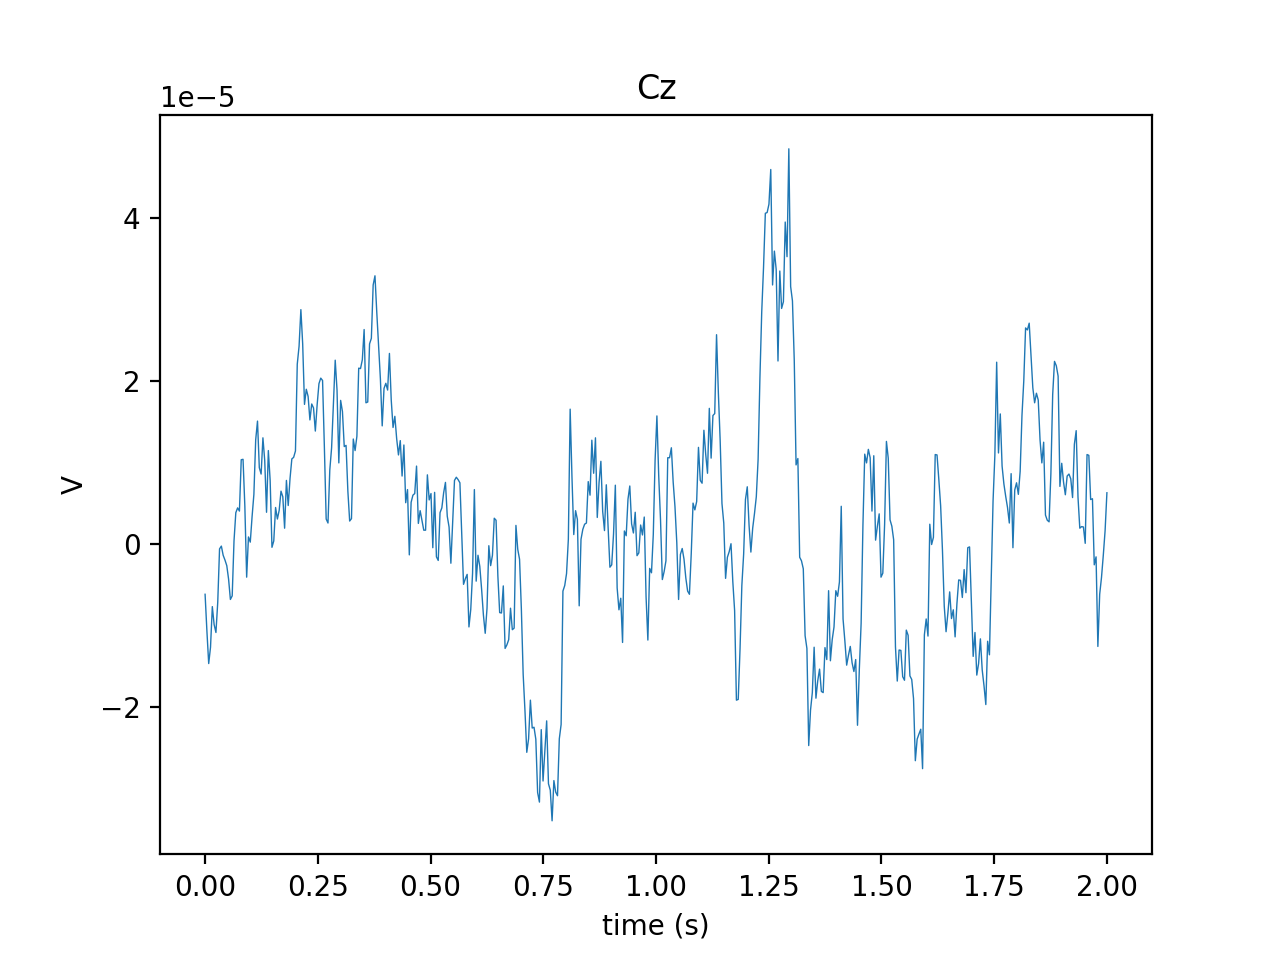

In [6]:
sfreq = int(raw_mne.info['sfreq'])
channels = array(raw_mne.info['ch_names'])
plot_signal(signal, sfreq, channels, 'Cz', n_seconds=2)

<IPython.core.display.Javascript object>


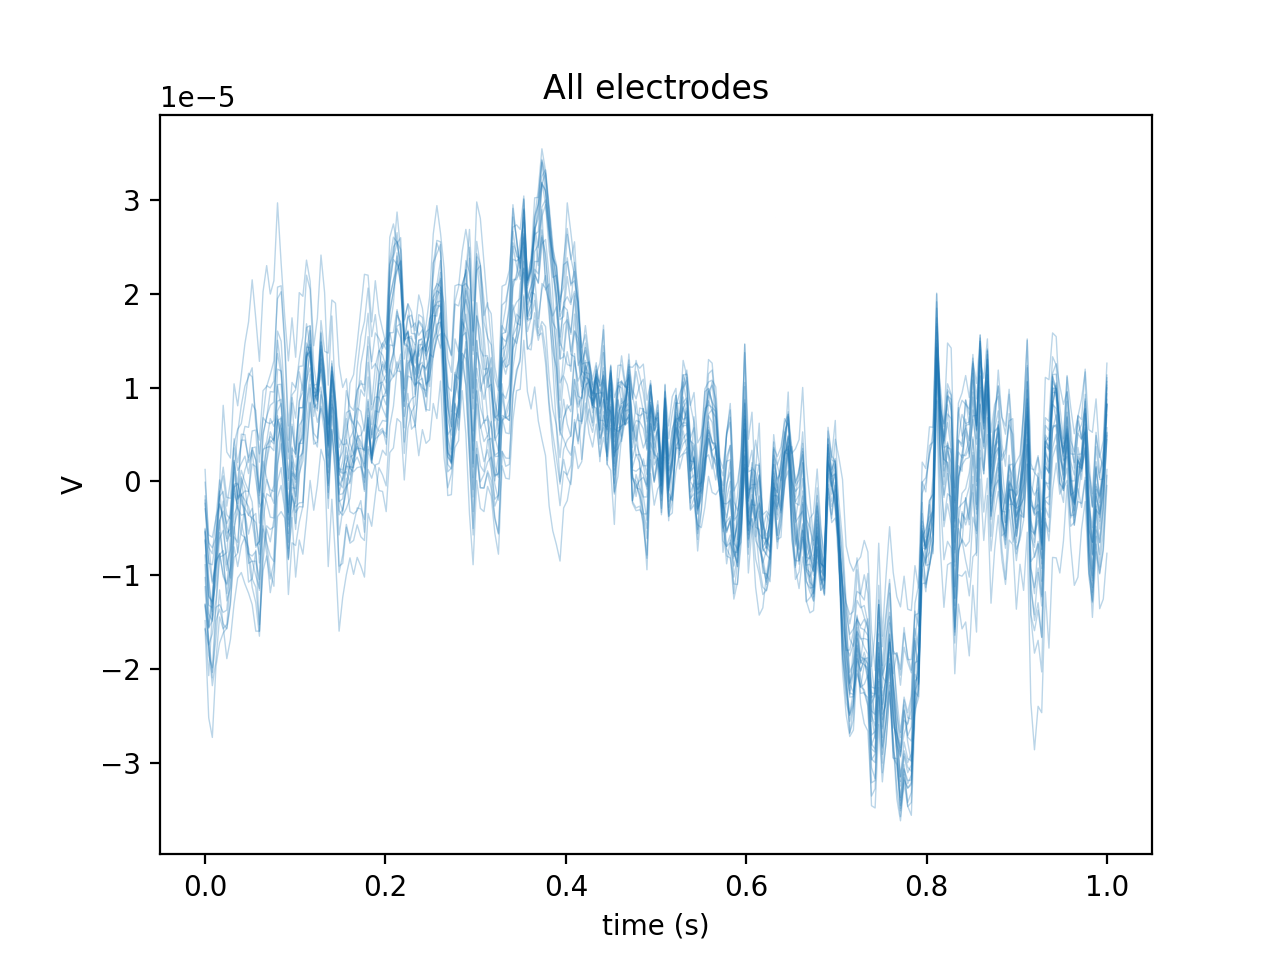

In [7]:
plot_signals(signal, sfreq, n_seconds=1)

In [8]:
X, labels = get_trials_data()
X.shape, labels.shape

((288, 22, 1001), (288,))

In [9]:
from pyriemann.estimation import Covariances

cov = Covariances().fit_transform(X)
cov.shape

(288, 22, 22)

<IPython.core.display.Javascript object>


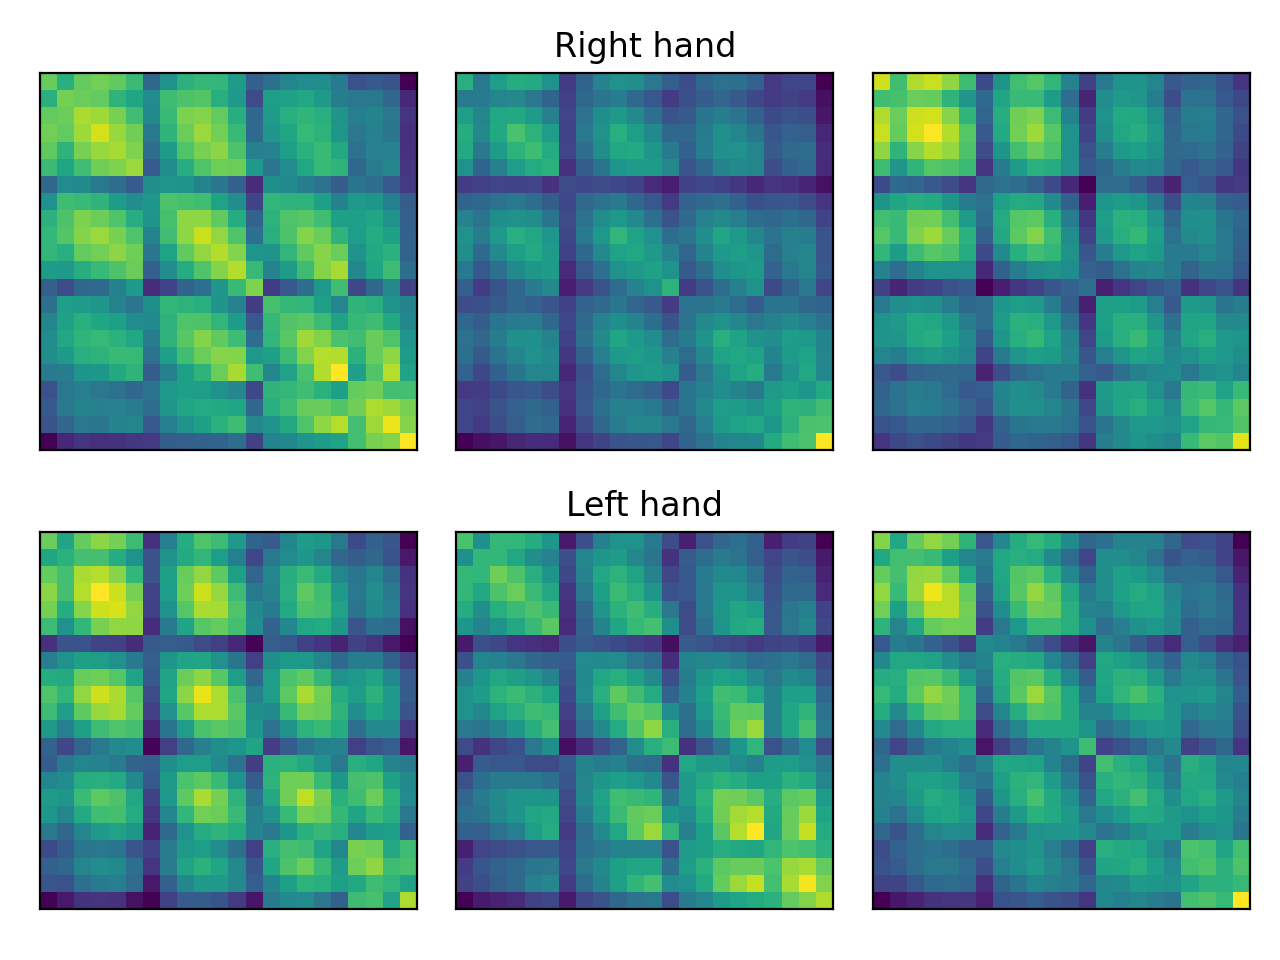

In [10]:
plot_cov(cov, labels, n=3)

In [11]:
from pyriemann.utils.mean import mean_riemann
mean = mean_riemann(cov)
mean.shape

(22, 22)

In [12]:
from pyriemann.utils.distance import distance_riemann
d = distance_riemann(cov[0], cov[1])
print(d)

3.691205440366134


<IPython.core.display.Javascript object>


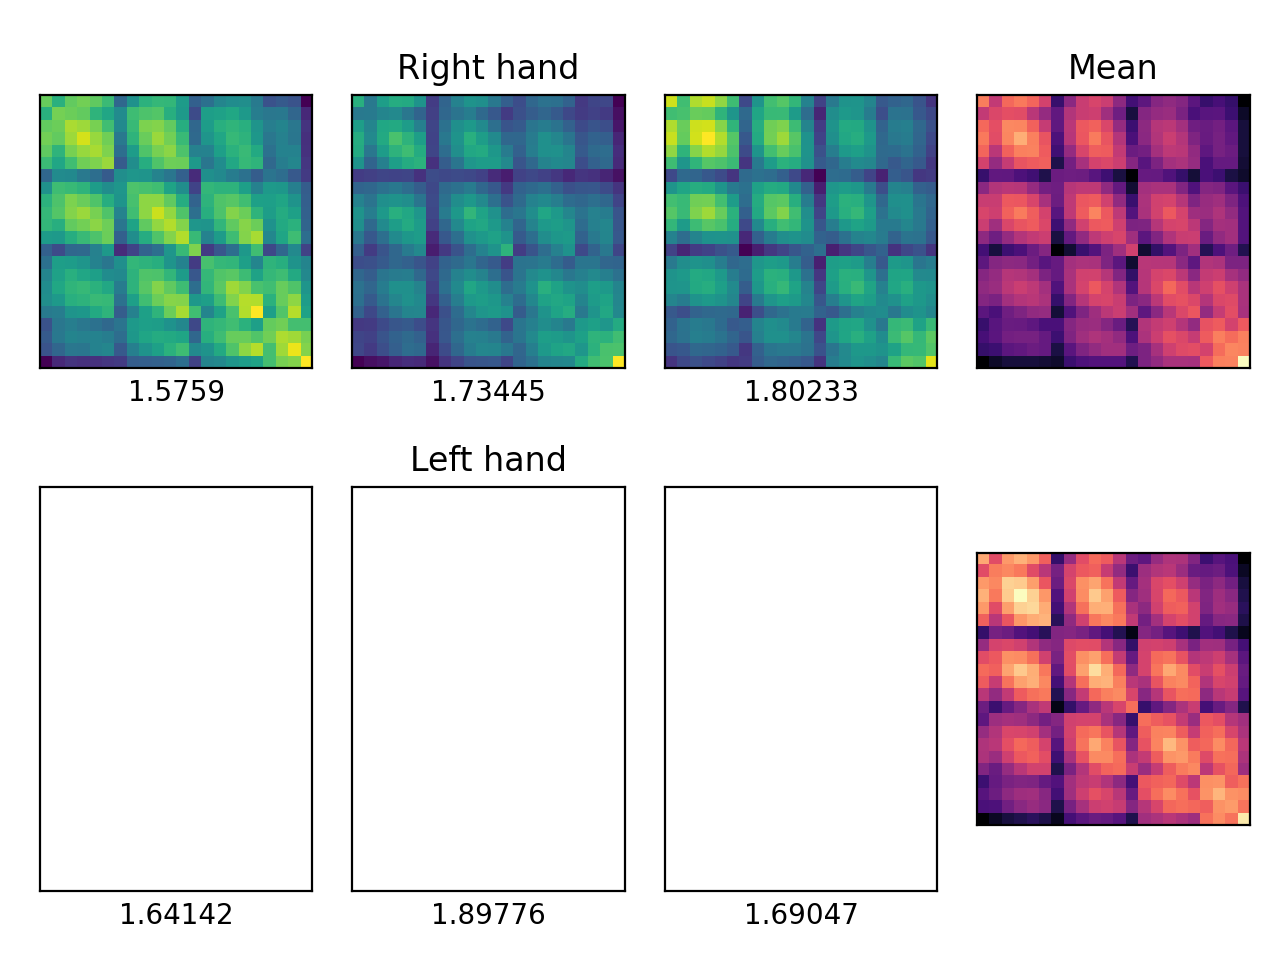

In [13]:
plot_cov_mean(cov, labels, n=3)

<IPython.core.display.Javascript object>


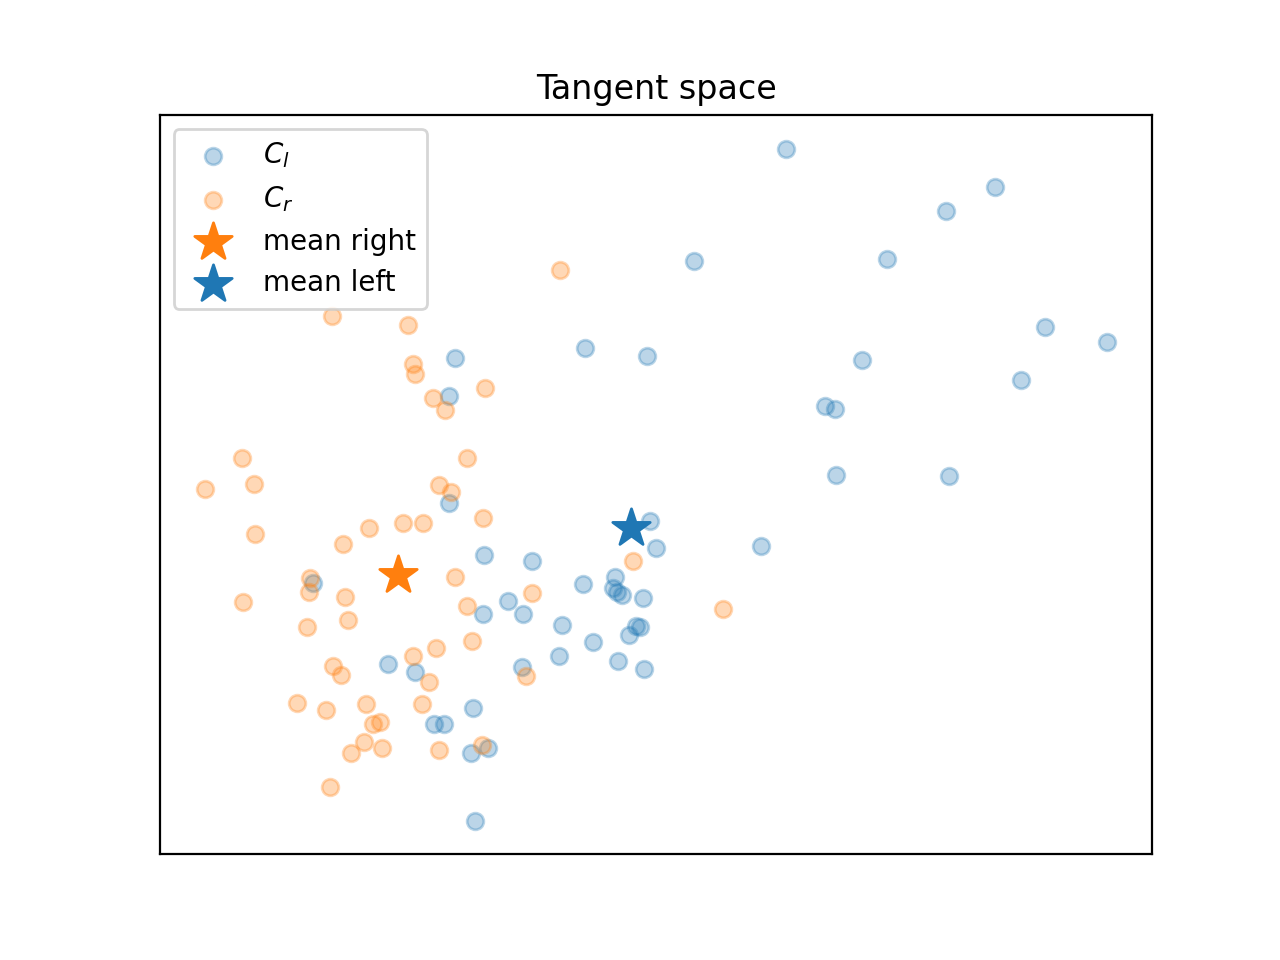

In [14]:
plot_cov_ts(cov, labels, n=50)

In [15]:
from sklearn.model_selection import train_test_split
cov_tr, cov_te, y_train, y_test = train_test_split(cov, labels, test_size=0.4, shuffle=False)

In [16]:
# train the MDM
right = arange(len(y_train))[y_train == 'right_hand']
left = arange(len(y_train))[y_train == 'left_hand']
classes = ['right_hand', 'left_hand']

mean_r = mean_riemann(cov_tr[right])
mean_l = mean_riemann(cov_tr[left])

In [17]:
# predict
y_pred = []
for c in cov_te:
    dist = [distance_riemann(c, mean_r), distance_riemann(c, mean_l)]
    y_pred.append(classes[array(dist).argmin()])
print(y_pred[:5])
print(list(y_test[:5]))

['right_hand', 'left_hand', 'left_hand', 'right_hand', 'right_hand']
['right_hand', 'left_hand', 'left_hand', 'left_hand', 'right_hand']


In [18]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred)
print ('Accuracy on test set is {:.2f}%'.format(acc))

Accuracy on test set is 0.85%


In [19]:
from pyriemann.classification import MDM

mdm = MDM(n_jobs=-1)
mdm.fit(cov_tr, y_train)
y_pred = mdm.predict(cov_te)
acc = accuracy_score(y_test, y_pred)
print ('Accuracy on test set is {:.2f}%'.format(acc))

Accuracy on test set is 0.85%


In [20]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

X, labels = get_trials_data()
mdm_ppl = make_pipeline(Covariances(), MDM(n_jobs=-1))
res = cross_validate(mdm_ppl, X, labels, scoring='accuracy', cv=5)

print(res["test_score"])
print("5-fold accuracy is {:.2f}% +/-{:.2f}".format(res["test_score"].mean(), res["test_score"].std()))

[0.72413793 0.87931034 0.86206897 0.85964912 0.87719298]
5-fold accuracy is 0.84% +/-0.06
